In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))


# فصل ۳ — تحلیل اکتشافی داده‌ها (EDA)
## درس ۳: تشخیص الگوها در داده‌ها

هدف عملی EDA تشخیص الگو است. «الگو» هر ساختاری است که **تکرارپذیر**، **قابل تفسیر** و **مفید** باشد؛ یعنی بتوان از آن برای پیش‌بینی، تصمیم‌گیری، یا اصلاح کیفیت داده استفاده کرد.

این درس روی *تفکر الگو* تمرکز دارد: شما از یک فرضیه شروع می‌کنید («چه نوع ساختاری ممکن است وجود داشته باشد؟»)، سپس با EDA شواهد جمع می‌کنید و در نهایت شواهد را در برابر خطاهای رایج محک می‌زنید (مخدوش‌سازی، پرت‌ها، نشتی، خطاهای نمونه‌گیری و دریفت زمانی).

برای تمرین، از چند دیتاست مختلف مخزن استفاده می‌کنیم تا مجموعه‌ابزار شما قابل تعمیم باشد، نه فقط مخصوص یک مثال.

### چه چیزی «الگو» محسوب می‌شود؟

الگو صرفاً «یک نمودار زیبا» نیست. الگو یک ادعاست که بتوان آن را دقیق بیان کرد، مثلاً:

- «قیمت به صورت غیرخطی با قیراط افزایش می‌یابد؛ در مقیاس لگاریتمی رابطه نزدیک به خطی است.»
- «میانگین Glucose در افراد دیابتی بالاتر است و این اختلاف با آزمون جایگشتی پایدار است.»
- «تصادف‌ها فصل‌وارگی هفتگی دارند؛ در لگ‌های نزدیک ۷ روز خودهمبستگی مثبت دیده می‌شود.»
- «انتخاب دارو با دسته BP مرتبط است و اندازه‌اثر قابل توجه است.»
- «روایت شکایت‌ها دریفت دارد؛ طول متوسط متن در طول زمان تغییر می‌کند.»

### اهداف یادگیری

در پایان این نوت‌بوک قادر خواهید بود:

1. یک مشاهده مبهم را به یک ادعای الگوی قابل آزمون تبدیل کنید.
2. برای الگوهای **تک‌متغیره**، **دومتغیره**، **گروهی**، **زمانی** و **دسته‌ای/متنی** ابزار مناسب را به‌کار ببرید.
3. تفاوت بین وابستگی خطی، یکنواخت و غیرخطی را تشخیص دهید.
4. پایداری الگو را با بوت‌استرپ و آزمون جایگشتی بررسی کنید.
5. خروجی‌های EDA تولید کنید که به گام‌های بعدی عملی منجر شود (مهندسی ویژگی، انتخاب مدل، اصلاح داده).


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 140)


## ۱) بارگذاری دیتاست‌ها و ایجاد زمینه

در کار واقعی معمولاً با یک «جدول عددی تمیز» طرف نیستیم. اغلب با موارد زیر روبه‌رو می‌شویم:

- ترکیب ویژگی‌های عددی و دسته‌ای،
- مفقودی و خطاهای تبدیل نوع داده،
- زمان‌مهرها و ساختارهای فصلی،
- سیگنال‌های ضعیف در فیلدهای متنی،
- و ناپایداری در زمان (دریفت).

برای تمرین گسترده، چند دیتاست را بررسی می‌کنیم:

- **Diabetes (طبقه‌بندی)**: ویژگی‌های عددی پزشکی + برچسب دودویی
- **Diamonds (رگرسیون)**: پویایی غیرخطی قیمت + بخش‌بندی‌هایی مثل cut
- **NYC collisions (رویداد/زمان)**: زمان‌مهر و الگوهای زمانی
- **Consumer complaints (نیمه‌متنی)**: روایت‌ها و مفقودی
- **Drug200 (غالباً دسته‌ای)**: الگوهای جدول توافقی
- **Airports (موجودیت/جغرافیا)**: الگوهای مکانی و دسته‌ها

هدف «تمام کردن تحلیل» هر دیتاست نیست؛ هدف تمرین روش‌های تشخیص الگو است.


In [3]:
from pathlib import Path

DATASETS = {
    "diabetes": "../../../Datasets/Classification/diabetes.csv",
    "diamonds": "../../../Datasets/Regression/diamonds.csv",
    "nyc_collisions": "../../../Datasets/Regression/NYC_Collisions.csv",
    "consumer_complaints": "../../../Datasets/Clustering/ConsumerComplaints.csv",
    "drug200": "../../../Datasets/Classification/drug200.csv",
    "airports": "../../../Datasets/Clustering/airports.csv",
}

def read_csv_strict(path, **kwargs):
    """Read a CSV from the repository path. Raises a clear error if the file is missing."""
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(
            f"CSV not found at: {path}.\n"
            "Run this notebook from the repository structure so relative paths resolve."
        )
    kwargs.setdefault("low_memory", False)
    return pd.read_csv(p, **kwargs)

# Load multiple datasets to practice pattern detection across different data modalities
df_diabetes = read_csv_strict(DATASETS["diabetes"])
df_diamonds = read_csv_strict(DATASETS["diamonds"])
df_nyc = read_csv_strict(DATASETS["nyc_collisions"])
df_cc = read_csv_strict(DATASETS["consumer_complaints"])
df_drug = read_csv_strict(DATASETS["drug200"])
df_airports = read_csv_strict(DATASETS["airports"])

display(df_diabetes.head())
display(df_diamonds.head())
display(df_nyc.head())
display(df_cc.head())
display(df_drug.head())
display(df_airports.head())


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic


,id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


,COLLISION_ID,ACCIDENT_DATE,ACCIDENT_TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,STREET NAME,CROSS STREET NAME,FULL ADDRESS,VEHICLE TYPE,CONTRIBUTING FACTOR,PERSONS INJURED,PERSONS KILLED,PEDESTRIANS INJURED,PEDESTRIANS KILLED,CYCLIST INJURED,CYCLIST KILLED,MOTORIST INJURED,MOTORIST KILLED
0,4380785,2021-01-01,00:00:00,QUEENS,11434.0,40.664536,-73.77314,NaN,NaN,145-8 175 STREET,Station Wagon/Sport Utility Vehicle,Unspecified,0.0,0,0,0,0,0,0,0
1,4380974,2021-01-01,00:00:00,QUEENS,11355.0,40.754375,-73.82340,BEECH AVENUE,KISSENA BOULEVARD,NaN,Sedan,Unspecified,0.0,0,0,0,0,0,0,0
2,4381080,2021-01-01,00:00:00,BROOKLYN,11203.0,40.658295,-73.93109,UTICA AVENUE,WINTHROP STREET,NaN,Station Wagon/Sport Utility Vehicle,Driver Inattention/Distraction,1.0,0,0,0,0,0,1,0
3,4381095,2021-01-01,00:00:00,BROOKLYN,11212.0,40.661873,-73.92878,NaN,NaN,108 EAST 91 STREET,Sedan,Unspecified,0.0,0,0,0,0,0,0,0
4,4381962,2021-01-01,00:00:00,NaN,NaN,40.834198,-73.85169,WESTCHESTER AVENUE,NaN,NaN,Sedan,Unspecified,1.0,0,1,0,0,0,0,0


,Date Received,Product Name,Sub Product,Issue,Sub Issue,Consumer Complaint Narrative,Company Public Response,Company,State Name,Zip Code,Tags,Consumer Consent Provided,Submitted via,Date Sent to Company,Company Response to Consumer,Timely Response,Consumer Disputed,Complaint ID
0,2013-07-29,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,NaN,NaN,Wells Fargo & Company,VA,24540,NaN,NaN,Phone,2013-07-30,Closed with explanation,Yes,No,468882
1,2013-07-29,Bank account or service,Checking account,Using a debit or ATM card,NaN,NaN,NaN,Wells Fargo & Company,CA,95992,Older American,NaN,Web,2013-07-31,Closed with explanation,Yes,No,468889
2,2013-07-29,Bank account or service,Checking account,"Account opening, closing, or management",NaN,NaN,NaN,Santander Bank US,NY,10065,NaN,NaN,Fax,2013-07-31,Closed,Yes,No,468879
3,2013-07-29,Bank account or service,Checking account,Deposits and withdrawals,NaN,NaN,NaN,Wells Fargo & Company,GA,30084,NaN,NaN,Web,2013-07-30,Closed with explanation,Yes,No,468949
4,2013-07-29,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Franklin Credit Management,CT,6106,NaN,NaN,Web,2013-07-30,Closed with explanation,Yes,No,475823


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,icao_code,iata_code,gps_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total RF Heliport,40.070985,-74.933689,11.0,NaN,US,US-PA,Bensalem,no,NaN,NaN,K00A,00A,https://www.penndot.pa.gov/TravelInPA/airports...,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,NaN,NaN,00AA,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,NaN,NaN,00AK,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,NaN,NaN,00AL,00AL,NaN,NaN,NaN
4,506791,00AN,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80.0,NaN,US,US-AK,King Salmon,no,NaN,NaN,00AN,00AN,NaN,NaN,NaN


In [4]:
def summarize_df(df, name="df"):
    print(f"{name}: shape={df.shape}")
    display(df.head(5))
    display(df.describe(include="all").T.head(18))

def missingness_table(df, top=20):
    miss = df.isna().mean().sort_values(ascending=False)
    out = pd.DataFrame({"missing_frac": miss, "missing_count": df.isna().sum()})
    return out.head(top)

def plot_missingness_heatmap(df, nrows=200, title="Missingness heatmap (sampled rows)"):
    sample = df.sample(min(nrows, len(df)), random_state=42)
    plt.figure(figsize=(12, 4))
    sns.heatmap(sample.isna(), cbar=False)
    plt.title(title)
    plt.xlabel("Columns")
    plt.ylabel("Sampled rows")
    plt.show()

def ecdf(x):
    x = pd.to_numeric(pd.Series(x), errors="coerce").dropna().to_numpy()
    x = np.sort(x)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

def mutual_information_binned(x, y, bins=12):
    """Heuristic MI estimator via discretization + mutual_info_score (for EDA screening)."""
    x = pd.to_numeric(pd.Series(x), errors="coerce").to_numpy()
    y = pd.to_numeric(pd.Series(y), errors="coerce").to_numpy()
    m = np.isfinite(x) & np.isfinite(y)
    x = x[m]; y = y[m]
    if x.size < 5:
        return float("nan")

    x_edges = np.histogram_bin_edges(x, bins=bins)
    y_edges = np.histogram_bin_edges(y, bins=bins)
    x_b = np.digitize(x, x_edges[1:-1], right=False)
    y_b = np.digitize(y, y_edges[1:-1], right=False)
    return float(mutual_info_score(x_b, y_b))

def bootstrap_corr(x, y, n_boot=2000, method="spearman", seed=42):
    rng = np.random.default_rng(seed)
    x = pd.to_numeric(pd.Series(x), errors="coerce").to_numpy()
    y = pd.to_numeric(pd.Series(y), errors="coerce").to_numpy()
    m = np.isfinite(x) & np.isfinite(y)
    x = x[m]; y = y[m]
    n = len(x)
    if n < 3:
        return float("nan"), float("nan"), float("nan")

    stats_ = np.empty(n_boot, dtype=float)
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        xb, yb = x[idx], y[idx]
        if method == "pearson":
            stats_[_] = np.corrcoef(xb, yb)[0, 1]
        else:
            stats_[_] = stats.spearmanr(xb, yb).correlation

    lo, hi = np.quantile(stats_, [0.025, 0.975])
    return float(np.nanmean(stats_)), float(lo), float(hi)

def permutation_test_mean_diff(x, labels, n_perm=4000, seed=42):
    rng = np.random.default_rng(seed)
    x = pd.to_numeric(pd.Series(x), errors="coerce").to_numpy()
    labels = np.asarray(labels)
    m = np.isfinite(x) & pd.notnull(labels)
    x = x[m]; labels = labels[m]
    g0 = x[labels == 0]; g1 = x[labels == 1]
    if len(g0) == 0 or len(g1) == 0:
        return float("nan"), float("nan")
    obs = np.mean(g1) - np.mean(g0)

    concat = np.concatenate([g0, g1])
    n0 = len(g0)
    more_extreme = 0
    for _ in range(n_perm):
        rng.shuffle(concat)
        diff = np.mean(concat[n0:]) - np.mean(concat[:n0])
        if abs(diff) >= abs(obs):
            more_extreme += 1
    p = (more_extreme + 1) / (n_perm + 1)
    return float(obs), float(p)

def simple_acf(x, max_lag=30):
    x = pd.to_numeric(pd.Series(x), errors="coerce").dropna().to_numpy()
    if x.size < max_lag + 2:
        return np.array([np.nan] * max_lag)
    x = x - x.mean()
    denom = np.dot(x, x)
    out = []
    for lag in range(1, max_lag + 1):
        out.append(np.dot(x[:-lag], x[lag:]) / denom)
    return np.array(out)

def cramers_v_from_crosstab(ct):
    chi2, p, dof, _ = stats.chi2_contingency(ct.values)
    n = ct.values.sum()
    r, c = ct.shape
    v = np.sqrt(chi2 / (n * (min(r, c) - 1)))
    return float(chi2), float(p), int(dof), float(v)


## ۲) چرخه تشخیص الگو

یک چرخه EDA قابل اتکا معمولاً پنج گام دارد:

1. **فرضیه‌سازی**: چه ساختارهایی منطقی است وجود داشته باشند؟ (تفکر مکانیزمی)
2. **کاوش**: تجسم و خلاصه‌سازی؛ جست‌وجوی سیگنال بدون «بیش‌برازش چشمی»
3. **کمّی‌سازی**: اندازه‌گیری قدرت (اندازه‌اثر، همبستگی، MI، آماره آزمون)
4. **استرس‌تست**: بررسی پایداری با بازنمونه‌گیری یا حذف نقاط مشکوک
5. **تصمیم**: تبدیل الگوها به اقدام بعدی (ویژگی‌ها، نوع تقسیم داده، پاکسازی، خانواده مدل)

مهارت مهم حرفه‌ای این است که بدانید «الگوهای تقلبی» از کجا می‌آیند، مثل:

- مخدوش‌سازی (متغیر سوم باعث ظاهر شدن ارتباط می‌شود)،
- نشتی (ویژگی‌ها به شکل غیرمستقیم برچسب را کد می‌کنند)،
- دریفت زمانی (روابط در طول زمان تغییر می‌کنند)،
- بایاس انتخاب (زیرمجموعه نماینده جامعه نیست)،
- یا مفقودی وابسته به هدف.


## ۳) پروفایل سریع: ابعاد، نوع داده، مفقودی

قبل از تفسیر الگوها مطمئن شوید جدول همان چیزی است که فکر می‌کنید:

- آیا ستون‌های عددی واقعاً عددی هستند (نه رشته با کاما/واحد)؟
- آیا ستون‌های دسته‌ای سازگارند (حروف بزرگ/کوچک، املا، فاصله‌ها)؟
- آیا شناسه‌ها یا ردیف‌های تکراری وجود دارد؟
- آیا مفقودی تصادفی به نظر می‌رسد یا در برخی گروه‌ها/زمان‌ها متمرکز است؟

این مرحله کار اضافی نیست: بخش زیادی از «کشف‌های» ظاهری EDA حاصل خطاهای dtype و مفقودی است.


df_diabetes: shape=(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,NaN,NaN,NaN,3.845052,3.369578,0.0,1.0,3.0,6.0,17.0
Glucose,768.0,NaN,NaN,NaN,120.894531,31.972618,0.0,99.0,117.0,140.25,199.0
BloodPressure,768.0,NaN,NaN,NaN,69.105469,19.355807,0.0,62.0,72.0,80.0,122.0
SkinThickness,768.0,NaN,NaN,NaN,20.536458,15.952218,0.0,0.0,23.0,32.0,99.0
Insulin,768.0,NaN,NaN,NaN,79.799479,115.244002,0.0,0.0,30.5,127.25,846.0
BMI,768.0,NaN,NaN,NaN,31.992578,7.88416,0.0,27.3,32.0,36.6,67.1
DiabetesPedigreeFunction,768.0,NaN,NaN,NaN,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,NaN,NaN,NaN,33.240885,11.760232,21.0,24.0,29.0,41.0,81.0
classification,768,2,Non-Diabetic,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN


df_diamonds: shape=(53940, 11)


,id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,53940.0,NaN,NaN,NaN,26970.5,15571.281097,1.0,13485.75,26970.5,40455.25,53940.0
carat,53940.0,NaN,NaN,NaN,0.79794,0.474011,0.2,0.4,0.7,1.04,5.01
cut,53940,5,Ideal,21551,NaN,NaN,NaN,NaN,NaN,NaN,NaN
color,53940,7,G,11292,NaN,NaN,NaN,NaN,NaN,NaN,NaN
clarity,53940,8,SI1,13065,NaN,NaN,NaN,NaN,NaN,NaN,NaN
depth,53940.0,NaN,NaN,NaN,61.749405,1.432621,43.0,61.0,61.8,62.5,79.0
table,53940.0,NaN,NaN,NaN,57.457184,2.234491,43.0,56.0,57.0,59.0,95.0
price,53940.0,NaN,NaN,NaN,3932.799722,3989.439738,326.0,950.0,2401.0,5324.25,18823.0
x,53940.0,NaN,NaN,NaN,5.731157,1.121761,0.0,4.71,5.7,6.54,10.74
y,53940.0,NaN,NaN,NaN,5.734526,1.142135,0.0,4.72,5.71,6.54,58.9


df_drug: shape=(200, 6)


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,200.0,NaN,NaN,NaN,44.315,16.544315,15.0,31.0,45.0,58.0,74.0
Sex,200,2,M,104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BP,200,3,HIGH,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cholesterol,200,2,HIGH,103,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Na_to_K,200.0,NaN,NaN,NaN,16.084485,7.223956,6.269,10.4455,13.9365,19.38,38.247
Drug,200,5,DrugY,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,missing_frac,missing_count
Company,0.000000,0
Company Public Response,0.962595,63049
Company Response to Consumer,0.000000,0
Complaint ID,0.000000,0
Consumer Complaint Narrative,0.960091,62885
Consumer Consent Provided,0.927327,60739
Consumer Disputed,0.016916,1108
Date Received,0.000000,0
Date Sent to Company,0.000000,0
Issue,0.000000,0


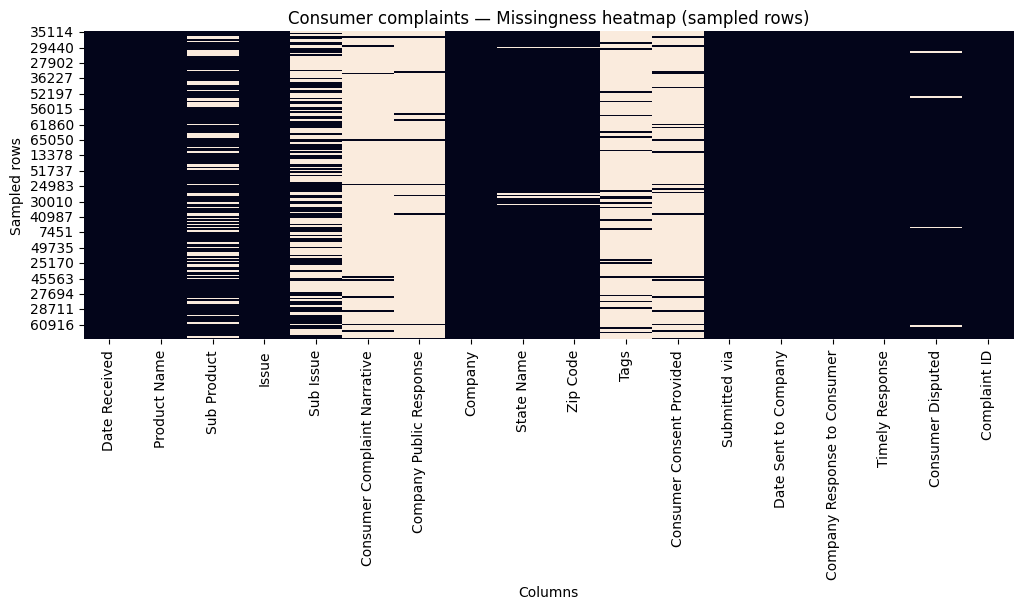

In [5]:
summarize_df(df_diabetes, "df_diabetes")
summarize_df(df_diamonds, "df_diamonds")
summarize_df(df_drug, "df_drug")

display(missingness_table(df_cc, top=15))
plot_missingness_heatmap(df_cc, nrows=200, title="Consumer complaints — Missingness heatmap (sampled rows)")


## ۴) الگوهای تک‌متغیره: چولگی، دُم‌ها، چندقله‌ای بودن

EDA تک‌متغیره به سؤال «هر متغیر به تنهایی چه شکلی دارد؟» پاسخ می‌دهد.

الگوهای رایج و پیامدهای آن‌ها:

- **چولگی راست** (مثل price): تبدیل $z=\log(1+x)$، مقیاس‌بندی مقاوم، یا تبدیل‌های کوانتایلی را در نظر بگیرید.
- **دُم‌های کلفت**: پرت‌ها می‌توانند میانگین را خراب کنند؛ میانه/کوانتایل‌ها خلاصه امن‌تری هستند.
- **چندقله‌ای بودن**: اغلب نشان‌دهنده ترکیب چند زیرجمعیت یا رژیم اندازه‌گیری است.
- **بریدگی/توده‌شدن**: گردکردن یا کلیپ شدن مقادیر (مثلاً صفرهای زیاد) می‌تواند محدودیت اندازه‌گیری را نشان دهد.

در ادامه price و carat را بررسی می‌کنیم و از ECDF (تابع توزیع تجمعی تجربی) استفاده می‌کنیم که بسیاری مواقع از هیستوگرام گویا‌تر است.


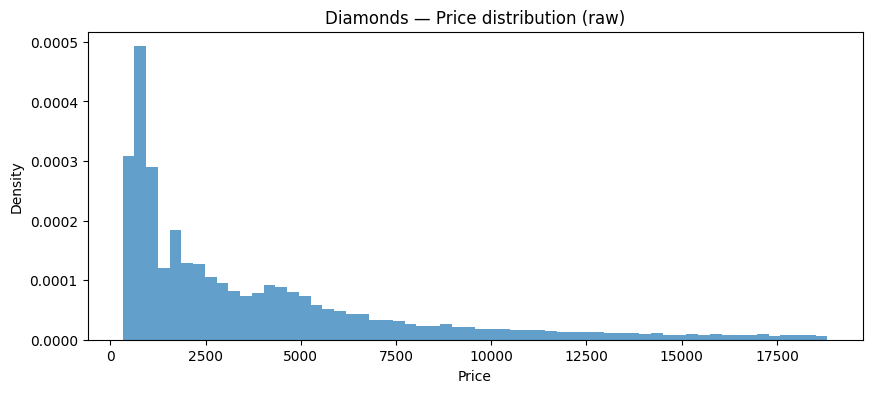

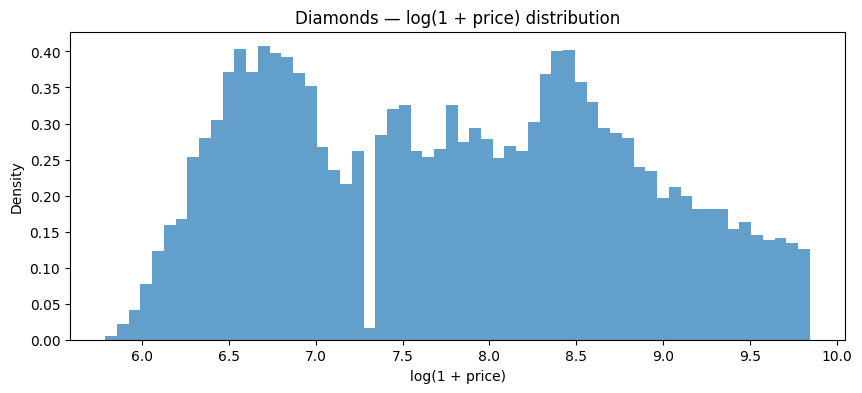

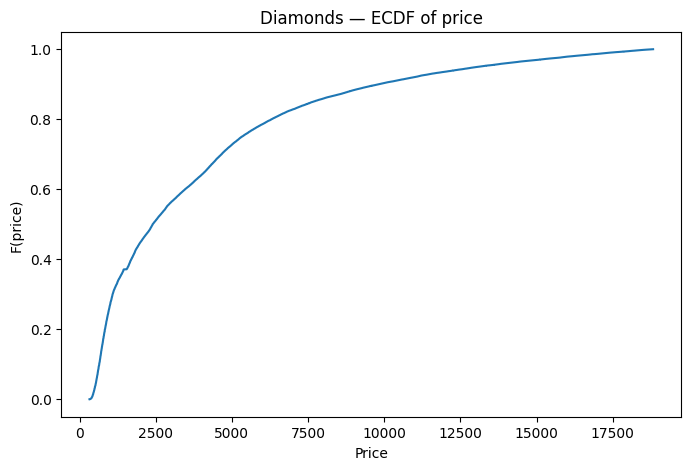

In [6]:
d = df_diamonds.copy()
for c in ["price","carat","depth","table","x","y","z"]:
    if c in d.columns:
        d[c] = pd.to_numeric(d[c], errors="coerce")

# Histograms
plt.figure(figsize=(10, 4))
plt.hist(d["price"].dropna(), bins=60, density=True, alpha=0.7)
plt.title("Diamonds — Price distribution (raw)")
plt.xlabel("Price")
plt.ylabel("Density")
plt.show()

plt.figure(figsize=(10, 4))
plt.hist(np.log1p(d["price"].dropna()), bins=60, density=True, alpha=0.7)
plt.title("Diamonds — log(1 + price) distribution")
plt.xlabel("log(1 + price)")
plt.ylabel("Density")
plt.show()

# ECDF
x, y = ecdf(d["price"])
plt.figure(figsize=(8, 5))
plt.plot(x, y)
plt.title("Diamonds — ECDF of price")
plt.xlabel("Price")
plt.ylabel("F(price)")
plt.show()


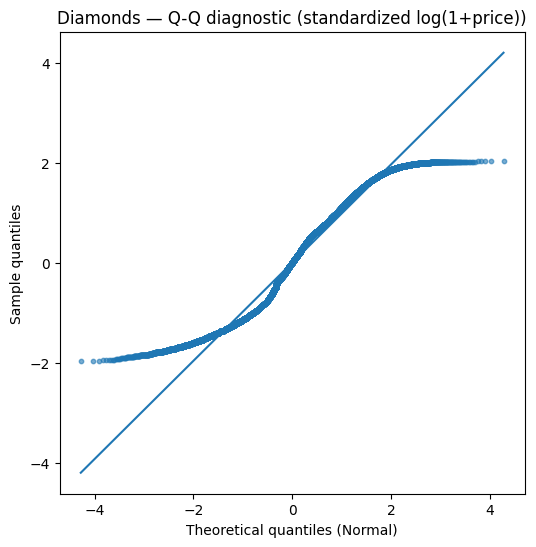

Skewness (price): 1.6183502776053016
Kurtosis (price): 2.177382669056634


In [7]:
# QQ-plot style diagnostic against Normal for log(1+price)
lp = np.log1p(d["price"].dropna())
lp = (lp - lp.mean()) / lp.std(ddof=0)

theoretical = stats.norm.ppf((np.arange(1, len(lp) + 1) - 0.5) / len(lp))
sample = np.sort(lp.to_numpy())

plt.figure(figsize=(6, 6))
plt.scatter(theoretical, sample, s=10, alpha=0.6)
m, b = np.polyfit(theoretical, sample, 1)
plt.plot(theoretical, m*theoretical + b)
plt.title("Diamonds — Q-Q diagnostic (standardized log(1+price))")
plt.xlabel("Theoretical quantiles (Normal)")
plt.ylabel("Sample quantiles")
plt.show()

# Tail check
print("Skewness (price):", stats.skew(d["price"].dropna()))
print("Kurtosis (price):", stats.kurtosis(d["price"].dropna(), fisher=True))


## ۵) الگوهای دومتغیره: خطی، یکنواخت، غیرخطی

EDA دومتغیره به سؤال «دو متغیر چگونه با هم تغییر می‌کنند؟» پاسخ می‌دهد.

### چرا چند معیار؟

- **پیرسون** وابستگی خطی را می‌سنجد.
- **اسپیرمن** وابستگی یکنواخت را می‌سنجد (رتبه‌ای).
- **MI** می‌تواند وابستگی‌های گسترده‌تر (حتی غیر یکنواخت) را آشکار کند.

هیچ آماره‌ای به تنهایی کافی نیست. رویکرد مقاوم:

1. رابطه را رسم کنید (scatter/hexbin).
2. پیرسون و اسپیرمن را محاسبه کنید.
3. اگر رابطه خمیده است، تبدیل یا خلاصه‌سازی شرطی انجام دهید.
4. بررسی کنید آیا الگو فقط توسط چند پرت ایجاد شده است یا نه.

در اینجا از diamonds استفاده می‌کنیم: carat در برابر price در مقیاس خام غیرخطی است و در مقیاس لگاریتمی نزدیک‌تر به خطی می‌شود.


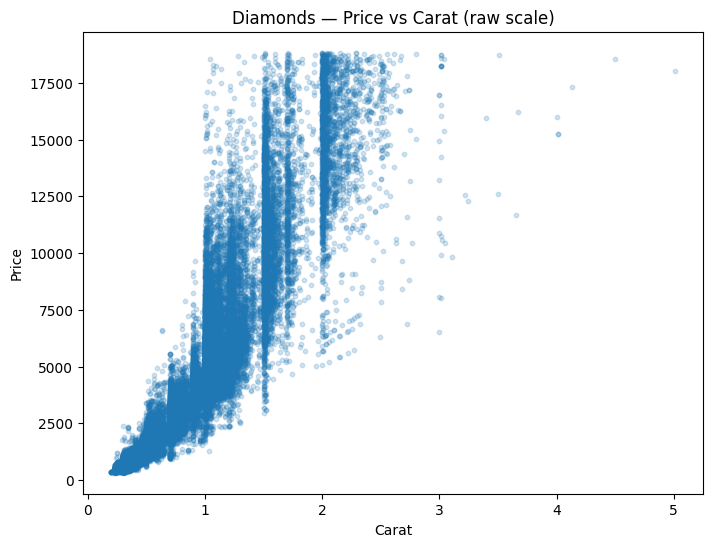

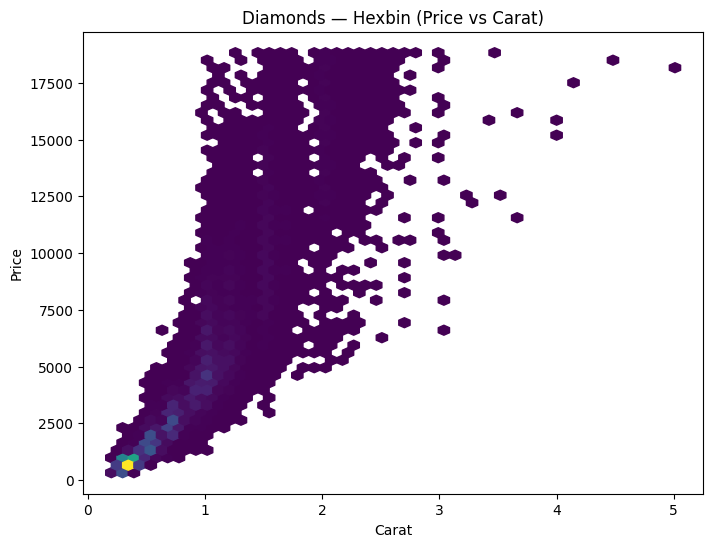

Pearson corr(carat, price): 0.921591301193476
Spearman corr(carat, price): 0.9628827988813001


In [8]:
d2 = d.dropna(subset=["carat","price"]).copy()

plt.figure(figsize=(8, 6))
plt.scatter(d2["carat"], d2["price"], s=10, alpha=0.2)
plt.title("Diamonds — Price vs Carat (raw scale)")
plt.xlabel("Carat")
plt.ylabel("Price")
plt.show()

plt.figure(figsize=(8, 6))
plt.hexbin(d2["carat"], d2["price"], gridsize=50, mincnt=1)
plt.title("Diamonds — Hexbin (Price vs Carat)")
plt.xlabel("Carat")
plt.ylabel("Price")
plt.show()

pearson_raw = np.corrcoef(d2["carat"], d2["price"])[0, 1]
spearman_raw = stats.spearmanr(d2["carat"], d2["price"]).correlation
print("Pearson corr(carat, price):", pearson_raw)
print("Spearman corr(carat, price):", spearman_raw)


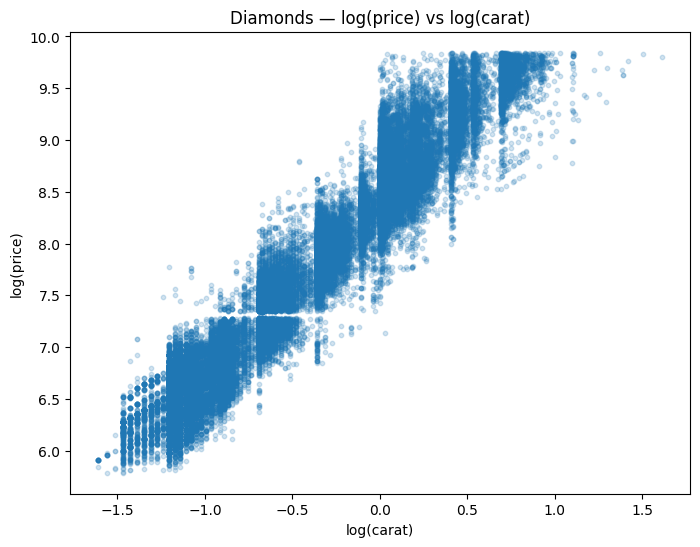

Pearson corr(log(carat), log(price)): 0.9659137166186668
Spearman corr(log(carat), log(price)): 0.9628827988813001


In [9]:
# Log–log view
x = np.log(d2["carat"])
y = np.log(d2["price"])

plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=10, alpha=0.2)
plt.title("Diamonds — log(price) vs log(carat)")
plt.xlabel("log(carat)")
plt.ylabel("log(price)")
plt.show()

pearson_ll = np.corrcoef(x, y)[0, 1]
spearman_ll = stats.spearmanr(x, y).correlation
print("Pearson corr(log(carat), log(price)):", pearson_ll)
print("Spearman corr(log(carat), log(price)):", spearman_ll)


## ۶) غربال‌گری وابستگی غیرخطی با MI

MI در استقلال برابر صفر است و با افزایش وابستگی بزرگ‌تر می‌شود. برآوردگرهای مختلفی وجود دارد؛ در اینجا یک برآورد ساده مبتنی بر گسسته‌سازی را برای **غربال‌گری EDA** به کار می‌بریم.

یک جریان کار مفید این است که MI بین یک متغیر کلیدی و چندین متغیر دیگر را محاسبه کنید و رتبه‌بندی کنید تا کاندیدهای تحلیل عمیق‌تر مشخص شوند.

در ادامه برای دیتاست diabetes این کار را انجام می‌دهیم: کدام ویژگی‌ها درباره Glucose (و همچنین درباره برچسب دودویی) اطلاع‌بخش‌تر هستند؟


In [10]:
df_diabetes = df_diabetes.copy()
df_diabetes["y"] = (df_diabetes["classification"].astype(str).str.lower().str.contains("diab")).astype(int)

num_cols = ["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age"]
for c in num_cols:
    df_diabetes[c] = pd.to_numeric(df_diabetes[c], errors="coerce")

# MI with Glucose
mi_with_glucose = []
for c in [col for col in num_cols if col != "Glucose"]:
    mi = mutual_information_binned(df_diabetes[c], df_diabetes["Glucose"], bins=12)
    mi_with_glucose.append((c, mi))

mi_glu = pd.DataFrame(mi_with_glucose, columns=["feature", "MI(feature, Glucose)"]).sort_values("MI(feature, Glucose)", ascending=False)
display(mi_glu)

# MI with label (y)
mi_with_y = []
for c in num_cols:
    mi = mutual_information_binned(df_diabetes[c], df_diabetes["y"], bins=8)
    mi_with_y.append((c, mi))

mi_y = pd.DataFrame(mi_with_y, columns=["feature", "MI(feature, y)"]).sort_values("MI(feature, y)", ascending=False)
display(mi_y)


,feature,"MI(feature, Glucose)"
3,Insulin,0.128345
6,Age,0.113149
1,BloodPressure,0.085101
4,BMI,0.073170
0,Pregnancies,0.070735
2,SkinThickness,0.062220
5,DiabetesPedigreeFunction,0.061245


,feature,"MI(feature, y)"
0,Pregnancies,0.0
1,Glucose,0.0
2,BloodPressure,0.0
3,SkinThickness,0.0
4,Insulin,0.0
5,BMI,0.0
6,DiabetesPedigreeFunction,0.0
7,Age,0.0


## ۷) الگوهای گروهی: جابه‌جایی توزیع با برچسب (Diabetes)

در یادگیری نظارتی، یک منبع مهم سیگنال این است که توزیع ویژگی‌ها بین گروه‌های تعریف‌شده توسط هدف (یا یک سگمنت کسب‌وکاری) تفاوت داشته باشد.

تحلیل حرفه‌ای به «boxplot فرق دارد» ختم نمی‌شود. شما معمولاً می‌خواهید:

- اندازه‌اثر (مثل Cohen’s d برای اختلاف استانداردشده میانگین)،
- بررسی پایداری (آزمون جایگشتی)،
- و تشخیص میزان همپوشانی (اگر همپوشانی زیاد باشد، پیش‌بینی سخت‌تر می‌شود).

در ادامه چند ویژگی مهم diabetes را به تفکیک برچسب مقایسه و اختلاف را کمّی‌سازی می‌کنیم.


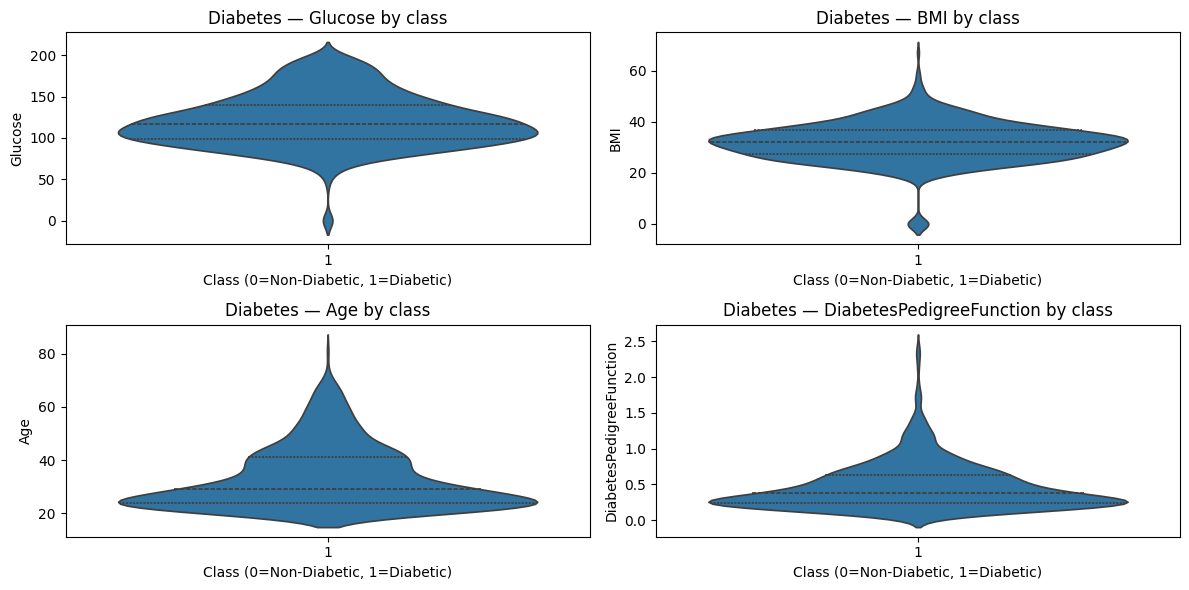

In [11]:
plt.figure(figsize=(12, 6))
for i, feat in enumerate(["Glucose", "BMI", "Age", "DiabetesPedigreeFunction"], start=1):
    plt.subplot(2, 2, i)
    sns.violinplot(data=df_diabetes, x="y", y=feat, inner="quartile")
    plt.title(f"Diabetes — {feat} by class")
    plt.xlabel("Class (0=Non-Diabetic, 1=Diabetic)")
    plt.ylabel(feat)
plt.tight_layout()
plt.show()


In [12]:
def cohens_d(a, b):
    a = pd.to_numeric(pd.Series(a), errors="coerce").dropna().to_numpy()
    b = pd.to_numeric(pd.Series(b), errors="coerce").dropna().to_numpy()
    if a.size < 2 or b.size < 2:
        return float("nan")

    with np.errstate(all="ignore"):
        var_a = a.var(ddof=1)
        var_b = b.var(ddof=1)
        pooled = np.sqrt(((a.size - 1) * var_a + (b.size - 1) * var_b) / (a.size + b.size - 2))

    if not np.isfinite(pooled) or pooled == 0:
        return float("nan")
    return float((a.mean() - b.mean()) / pooled)

rows = []
for feat in ["Glucose","BMI","Age","DiabetesPedigreeFunction"]:
    dval = cohens_d(df_diabetes.loc[df_diabetes["y"]==1, feat], df_diabetes.loc[df_diabetes["y"]==0, feat])
    obs, p = permutation_test_mean_diff(df_diabetes[feat], df_diabetes["y"], n_perm=2500)
    rows.append((feat, dval, obs, p))

out = pd.DataFrame(rows, columns=["feature","Cohen_d(1-0)","mean_diff(1-0)","perm_p_value"])
display(out.sort_values("Cohen_d(1-0)", ascending=False))


,feature,Cohen_d(1-0),mean_diff(1-0),perm_p_value
0,Glucose,NaN,NaN,NaN
1,BMI,NaN,NaN,NaN
2,Age,NaN,NaN,NaN
3,DiabetesPedigreeFunction,NaN,NaN,NaN


## ۸) مخدوش‌سازی و اثرات شبیه سیمپسون (Diamonds)

یکی از خطاهای رایج EDA این است که یک الگوی کلی را ادعا کنیم که با شرطی‌سازی روی متغیر سوم ضعیف یا حتی معکوس شود.

مثلاً price و carat مرتبط‌اند، اما *قدرت* رابطه ممکن است به cut یا clarity وابسته باشد و همبستگی تجمعی گمراه‌کننده شود.

تشخیص عملی:

- رابطه را به صورت کلی بسنجید.
- همان رابطه را درون گروه‌ها (cut، clarity، color) بسنجید.
- مقایسه کنید: آیا شیب/همبستگی‌ها بین گروه‌ها تفاوت قابل توجه دارند؟

اگر بله، احتمالاً به تعامل‌ها یا مدل‌سازی سگمنت‌شده نیاز دارید.


Overall Spearman(carat, price): 0.9628827988813001


,cut,n,spearman_rho
4,Very Good,12082,0.968853
3,Premium,13791,0.960533
1,Good,4906,0.959968
2,Ideal,21551,0.953728
0,Fair,1610,0.905614


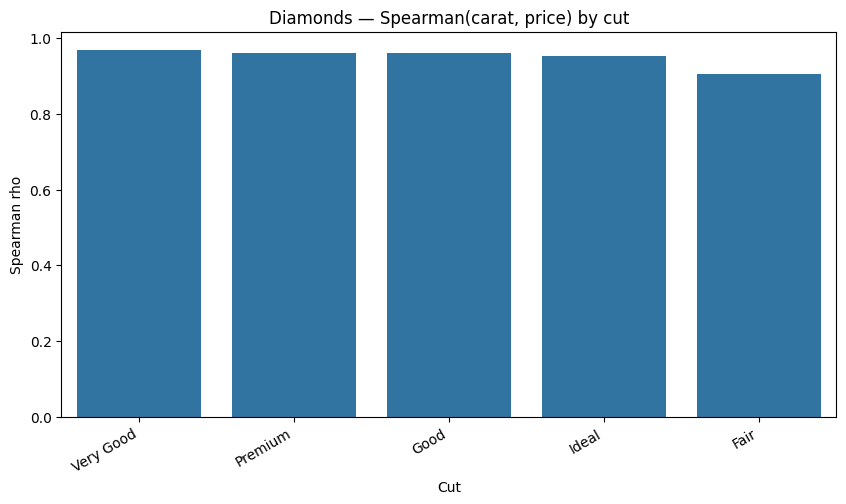

In [13]:
d3 = df_diamonds.dropna(subset=["carat","price","cut"]).copy()
d3["carat"] = pd.to_numeric(d3["carat"], errors="coerce")
d3["price"] = pd.to_numeric(d3["price"], errors="coerce")
d3 = d3.dropna(subset=["carat","price"])

overall = stats.spearmanr(d3["carat"], d3["price"]).correlation
print("Overall Spearman(carat, price):", overall)

by_cut = []
for cut, sub in d3.groupby("cut"):
    if len(sub) >= 50:
        rho = stats.spearmanr(sub["carat"], sub["price"]).correlation
        by_cut.append((cut, len(sub), rho))
by_cut = pd.DataFrame(by_cut, columns=["cut","n","spearman_rho"]).sort_values("spearman_rho", ascending=False)
display(by_cut)

plt.figure(figsize=(10, 5))
sns.barplot(data=by_cut, x="cut", y="spearman_rho")
plt.title("Diamonds — Spearman(carat, price) by cut")
plt.xlabel("Cut")
plt.ylabel("Spearman rho")
plt.xticks(rotation=30, ha="right")
plt.show()


## ۹) تعامل‌ها: خلاصه‌سازی شرطی و نماهای دوبعدی

وقتی روابط غیرخطی هستند، یک ابزار بسیار مفید EDA «میانگین/میانه شرطی» است:

- $x$ را به بازه‌ها (کوانتایل‌ها) تقسیم کنید،
- $y$ را در هر بازه خلاصه کنید (میانگین/میانه)،
- در صورت نیاز روی یک متغیر سگمنت نیز تفکیک کنید.

این روش شکل رابطه را بدون برازش مدل آشکار می‌کند.

در ادامه:

- قیراط را به دهک‌ها تقسیم می‌کنیم،
- میانه قیمت را در هر دهک محاسبه می‌کنیم،
- و برای هر cut یک خط جدا رسم می‌کنیم.

سپس یک هیت‌مپ دوبعدی می‌سازیم: بین قیراط × بین depth → میانه قیمت.


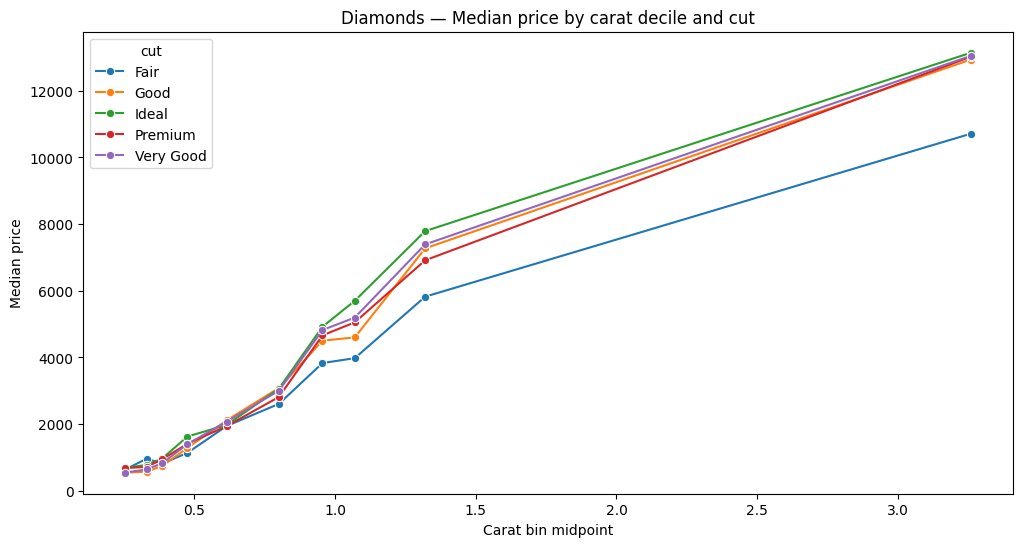

In [14]:
df = df_diamonds.copy()
df["carat"] = pd.to_numeric(df["carat"], errors="coerce")
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df["depth"] = pd.to_numeric(df["depth"], errors="coerce")
df = df.dropna(subset=["carat","price","cut","depth"]).copy()

df["carat_bin"] = pd.qcut(df["carat"], q=10, duplicates="drop")
df["carat_bin_mid"] = df["carat_bin"].apply(lambda itv: itv.mid)

med_by_cut = (
    df.groupby(["carat_bin_mid", "cut"], observed=True)["price"]
      .median()
      .reset_index()
      .sort_values("carat_bin_mid")
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=med_by_cut, x="carat_bin_mid", y="price", hue="cut", marker="o")
plt.title("Diamonds — Median price by carat decile and cut")
plt.xlabel("Carat bin midpoint")
plt.ylabel("Median price")
plt.show()


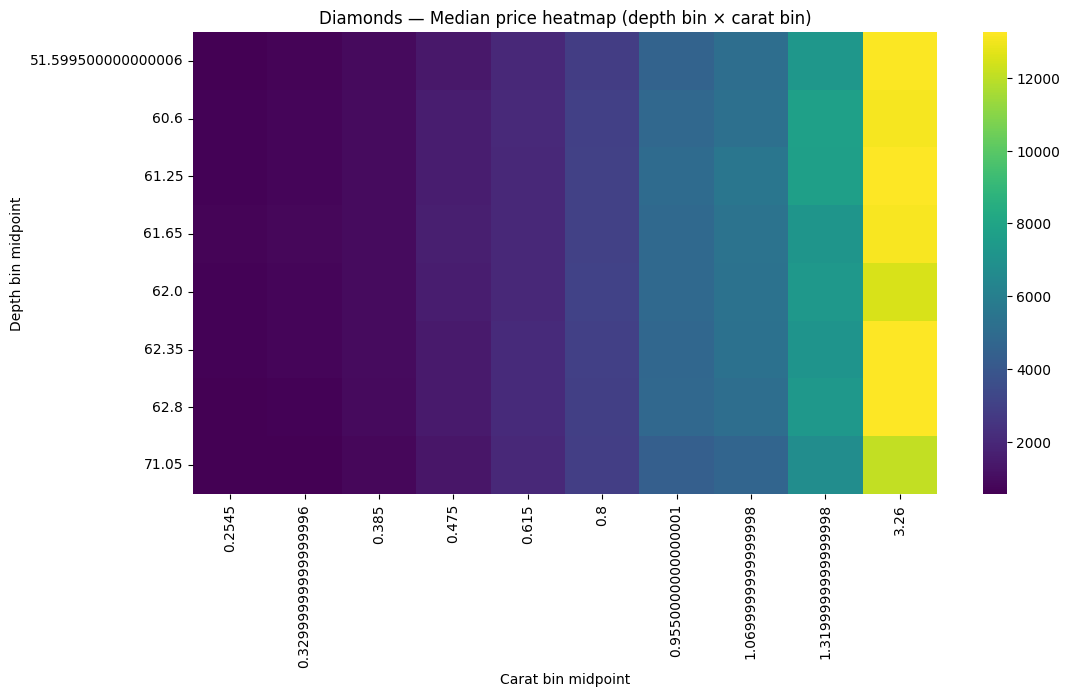

In [15]:
# 2D binning: carat vs depth -> median price
df["depth_bin"] = pd.qcut(df["depth"], q=8, duplicates="drop")
df["depth_bin_mid"] = df["depth_bin"].apply(lambda itv: itv.mid)

pivot = df.pivot_table(
    index="depth_bin_mid",
    columns="carat_bin_mid",
    values="price",
    aggfunc="median",
    observed=True
).sort_index()

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap="viridis")
plt.title("Diamonds — Median price heatmap (depth bin × carat bin)")
plt.xlabel("Carat bin midpoint")
plt.ylabel("Depth bin midpoint")
plt.show()


## ۱۰) تشخیص الگوی دسته‌ای (Drug200): جدول توافقی، کای-دو، اندازه‌اثر

برای ویژگی‌های دسته‌ای، الگوها معمولاً به صورت **وابستگی** بین دسته‌ها ظاهر می‌شوند.

رویکرد استاندارد:

1. ساخت جدول توافقی (cross-tab)
2. آزمون استقلال کای-دو
3. اندازه‌اثر (Cramér’s V)
4. تجسم با هیت‌مپ نرمال‌شده سطری

در اینجا BP × Drug را تحلیل می‌کنیم.


Drug,DrugY,drugA,drugB,drugC,drugX
BP,,,,,
HIGH,38,23,16,0,0
LOW,30,0,0,16,18
NORMAL,23,0,0,0,36


Chi-square: 143.2328718496999 dof: 8 p-value: 5.0417334144665895e-27
Cramer's V: 0.5983996821725842


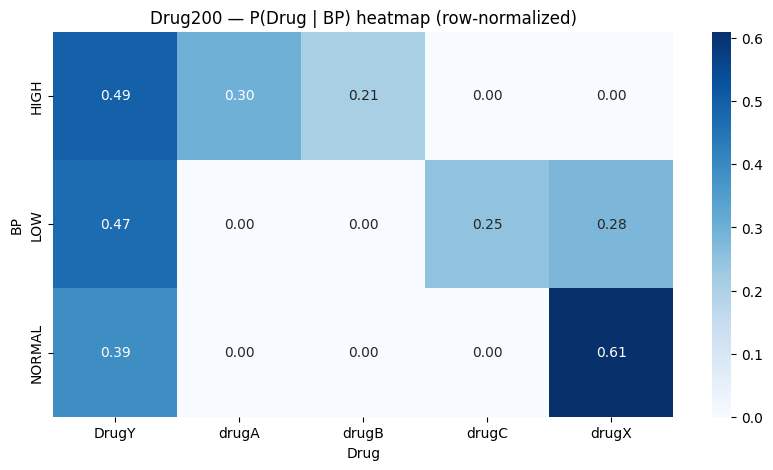

In [16]:
ct = pd.crosstab(df_drug["BP"], df_drug["Drug"])
display(ct)

chi2, p, dof, v = cramers_v_from_crosstab(ct)
print("Chi-square:", chi2, "dof:", dof, "p-value:", p)
print("Cramer's V:", v)

row_norm = ct.div(ct.sum(axis=1), axis=0)

plt.figure(figsize=(10, 5))
sns.heatmap(row_norm, annot=True, fmt=".2f", cmap="Blues")
plt.title("Drug200 — P(Drug | BP) heatmap (row-normalized)")
plt.ylabel("BP")
plt.xlabel("Drug")
plt.show()


## ۱۱) الگوهای زمانی (NYC collisions): روند، فصل‌وارگی هفتگی، ACF

زمان الگوهای جدیدی وارد می‌کند:

- روند (دریفت بلندمدت)،
- فصل‌وارگی (چرخه‌های هفتگی/روزانه)،
- جهش‌ها (رویدادهای خاص)،
- خودهمبستگی (وابستگی بین زمان‌ها).

در ادامه یک سری شمارش روزانه می‌سازیم، میانگین روزِهفته را محاسبه می‌کنیم و ACF را تا لگ ۳۰ بررسی می‌کنیم.


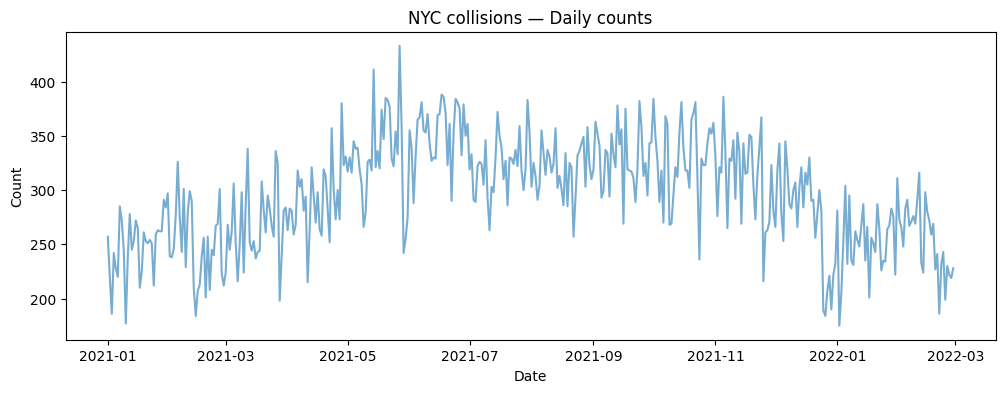

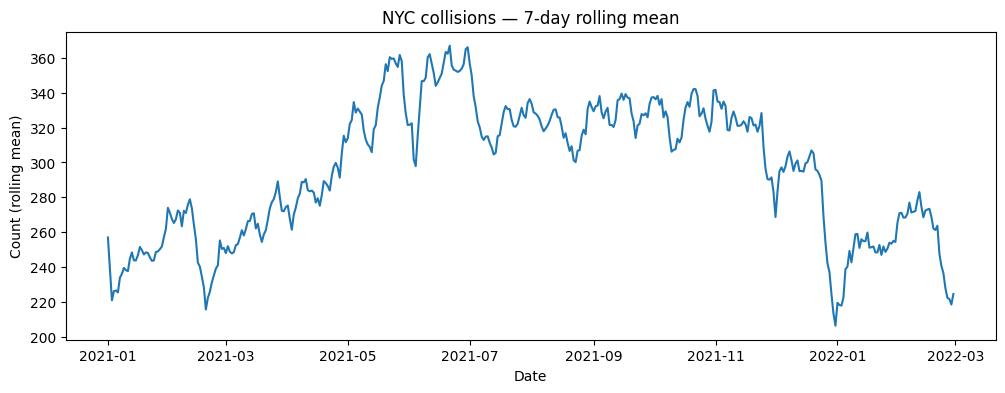

In [17]:
df_nyc = df_nyc.copy()
df_nyc["ACCIDENT_DATE"] = pd.to_datetime(df_nyc["ACCIDENT_DATE"], errors="coerce")
df_nyc = df_nyc.dropna(subset=["ACCIDENT_DATE"])

daily = df_nyc.groupby(df_nyc["ACCIDENT_DATE"].dt.date)["COLLISION_ID"].count().rename("count").to_frame()
daily.index = pd.to_datetime(daily.index)

plt.figure(figsize=(12, 4))
plt.plot(daily.index, daily["count"].values, alpha=0.6)
plt.title("NYC collisions — Daily counts")
plt.xlabel("Date")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(daily.index, daily["count"].rolling(7, min_periods=1).mean().values)
plt.title("NYC collisions — 7-day rolling mean")
plt.xlabel("Date")
plt.ylabel("Count (rolling mean)")
plt.show()


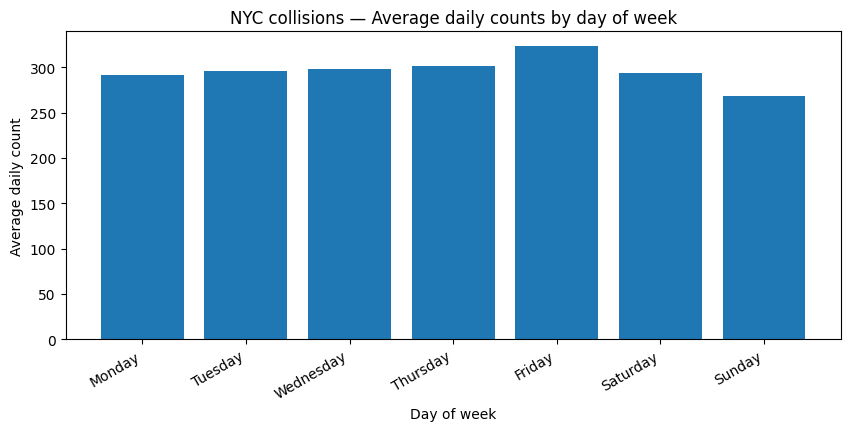

In [18]:
# Day-of-week averages
dow = daily.copy()
dow["dow"] = dow.index.day_name()
dow_mean = dow.groupby("dow")["count"].mean().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)

plt.figure(figsize=(10, 4))
plt.bar(dow_mean.index, dow_mean.values)
plt.title("NYC collisions — Average daily counts by day of week")
plt.xlabel("Day of week")
plt.ylabel("Average daily count")
plt.xticks(rotation=30, ha="right")
plt.show()


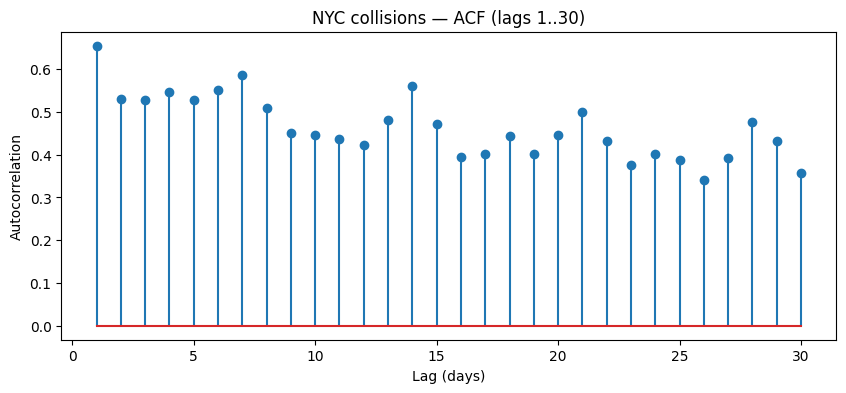

ACF at lag 7 (weekly): 0.5871697630432544


In [19]:
# Autocorrelation
acf_vals = simple_acf(daily["count"], max_lag=30)

plt.figure(figsize=(10, 4))
plt.stem(range(1, 31), acf_vals)
plt.title("NYC collisions — ACF (lags 1..30)")
plt.xlabel("Lag (days)")
plt.ylabel("Autocorrelation")
plt.show()

print("ACF at lag 7 (weekly):", acf_vals[6])


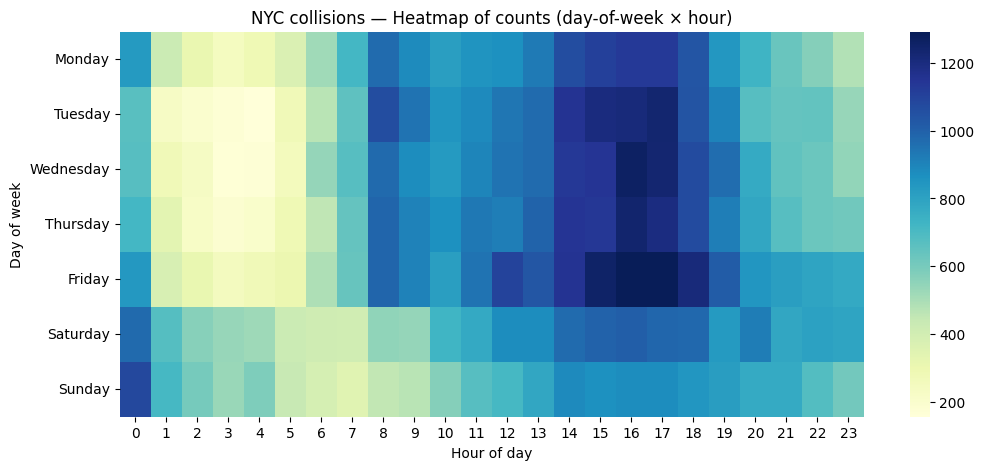

In [20]:
# Heatmap of day-of-week × hour-of-day
df_nyc2 = df_nyc.copy()
t = pd.to_datetime(df_nyc2["ACCIDENT_TIME"], format="%H:%M:%S", errors="coerce")
t2 = pd.to_datetime(df_nyc2["ACCIDENT_TIME"], format="%H:%M", errors="coerce")
df_nyc2["ACCIDENT_TIME"] = t.fillna(t2).dt.time
df_nyc2["hour"] = df_nyc2["ACCIDENT_TIME"].apply(lambda t: t.hour if t is not None else np.nan)
df_nyc2["dow"] = df_nyc2["ACCIDENT_DATE"].dt.day_name()

heat = pd.pivot_table(
    df_nyc2.dropna(subset=["hour"]),
    index="dow",
    columns="hour",
    values="COLLISION_ID",
    aggfunc="count",
    fill_value=0
)

order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
heat = heat.reindex(order)

plt.figure(figsize=(12, 5))
sns.heatmap(heat, cmap="YlGnBu")
plt.title("NYC collisions — Heatmap of counts (day-of-week × hour)")
plt.xlabel("Hour of day")
plt.ylabel("Day of week")
plt.show()


## ۱۲) الگوهای نیمه‌متنی (Consumer complaints): طول، مفقودی، واژه‌های پرتکرار

حتی بدون NLP عمیق می‌توان الگوهای ارزشمند دید:

- **مفقودی به تفکیک گروه** (کدام محصول/شرکت روایت را بیشتر خالی می‌گذارد؟)،
- **توزیع طول متن** (شکایت‌های کوتاه در برابر بلند)،
- **دریفت طول متوسط** در زمان،
- **واژه‌های پرتکرار** برای سیگنال سریع از موضوعات غالب (شمارش کیسه‌واژه).

در ادامه:

1. ستون روایت را (اگر وجود داشته باشد) پیدا می‌کنیم،
2. ویژگی‌های طول را می‌سازیم،
3. مفقودی را به تفکیک product/company مقایسه می‌کنیم،
4. با `CountVectorizer` یک جدول واژه‌های پرتکرار می‌سازیم.


Narrative column: Consumer Complaint Narrative


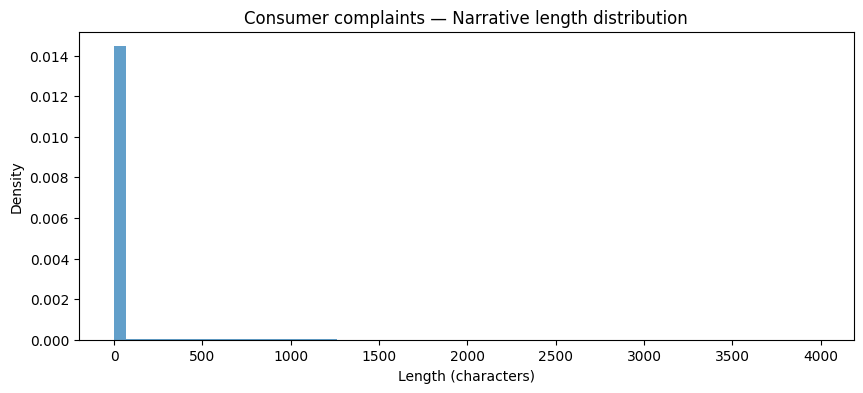

,share_with_text
Product Name,
Bank account or service,0.030734
Mortgage,0.031867
Credit reporting,0.035809
Money transfers,0.037475
Debt collection,0.046070
Credit card,0.046354
Other financial service,0.054545
Payday loan,0.056872
Consumer Loan,0.062740


,share_with_text
Company,
"Zarzaur and Schwartz, PC",0.0
"ATG Credit, LLC",0.0
"ACG Funding, Inc.",0.0
"Retrieval-Masters Creditors Bureau, Inc.",0.0
"AC Autopay, LLC",0.0
AARON DELGADO AND ASSOCIATES INC,0.0
AAA Collections,0.0
"A/R CONCEPTS, INC.",0.0
"A & S Collection Associates, Inc.",0.0


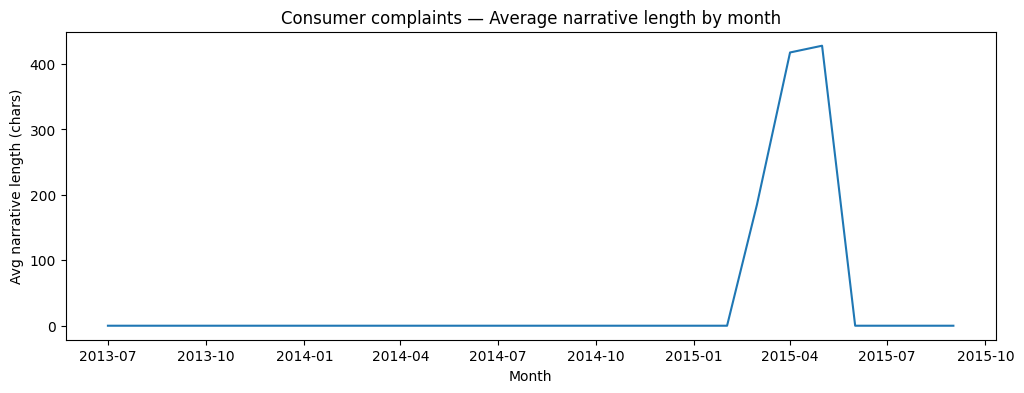

,term,count
24,xxxx,2165
6,credit,296
23,xx,268
1,account,236
0,00,199
11,loan,170
15,payment,150
8,did,144
22,told,141
2,bank,128


In [21]:
df_cc2 = df_cc.copy()

# Identify a narrative-like column
narr_col = None
for cand in ["Consumer Complaint Narrative", "Consumer complaint narrative", "Complaint", "Narrative"]:
    if cand in df_cc2.columns:
        narr_col = cand
        break

print("Narrative column:", narr_col)

if narr_col is not None:
    df_cc2["text"] = df_cc2[narr_col].fillna("").astype(str)
    df_cc2["text_len"] = df_cc2["text"].str.len()
    df_cc2["has_text"] = (df_cc2["text_len"] > 0).astype(int)

    plt.figure(figsize=(10, 4))
    plt.hist(df_cc2["text_len"], bins=60, density=True, alpha=0.7)
    plt.title("Consumer complaints — Narrative length distribution")
    plt.xlabel("Length (characters)")
    plt.ylabel("Density")
    plt.show()

    # Missingness by Product Name / Company if columns exist
    grp_cols = []
    if "Product Name" in df_cc2.columns:
        grp_cols.append("Product Name")
    if "Company" in df_cc2.columns:
        grp_cols.append("Company")

    for gc in grp_cols[:2]:
        rate = df_cc2.groupby(gc)["has_text"].mean().sort_values(ascending=True).head(12)
        display(rate.to_frame("share_with_text"))

    # Drift over time if date exists
    date_col = "Date Received" if "Date Received" in df_cc2.columns else None
    if date_col:
        tmp = df_cc2.copy()
        tmp[date_col] = pd.to_datetime(tmp[date_col], errors="coerce")
        tmp = tmp.dropna(subset=[date_col])
        tmp["month"] = tmp[date_col].dt.to_period("M").dt.to_timestamp()
        drift = tmp.groupby("month")["text_len"].mean()

        plt.figure(figsize=(12, 4))
        plt.plot(drift.index, drift.values)
        plt.title("Consumer complaints — Average narrative length by month")
        plt.xlabel("Month")
        plt.ylabel("Avg narrative length (chars)")
        plt.show()

    # Top terms via simple bag-of-words (with basic filtering)
    texts = df_cc2["text"].sample(min(5000, len(df_cc2)), random_state=42).tolist()
    vec = CountVectorizer(stop_words="english", max_features=25, min_df=5)
    X = vec.fit_transform(texts)
    terms = vec.get_feature_names_out()
    counts = np.asarray(X.sum(axis=0)).ravel()
    top_terms = pd.DataFrame({"term": terms, "count": counts}).sort_values("count", ascending=False)
    display(top_terms)
else:
    print("No narrative-like column found; skipping text diagnostics.")


## ۱۳) الگوهای مکانی/موجودیتی (Airports): خوشه‌ها و پرت‌ها

دیتاست‌های مکانی معمولاً الگوهای زیر را نشان می‌دهند:

- خوشه‌بندی بر اساس منطقه،
- تفاوت توزیع بر حسب نوع فرودگاه،
- و «پرت‌ها» که ممکن است خطا یا موارد نادر باشند (مثلاً elevation غیرعادی).

در ادامه:

1. latitude/longitude را تمیز می‌کنیم،
2. نقاط را تجسم می‌کنیم،
3. K-Means را روی فضای (lat, lon) به عنوان لنز EDA اجرا می‌کنیم،
4. و پرت‌های elevation را با z-score مقاوم بررسی می‌کنیم.


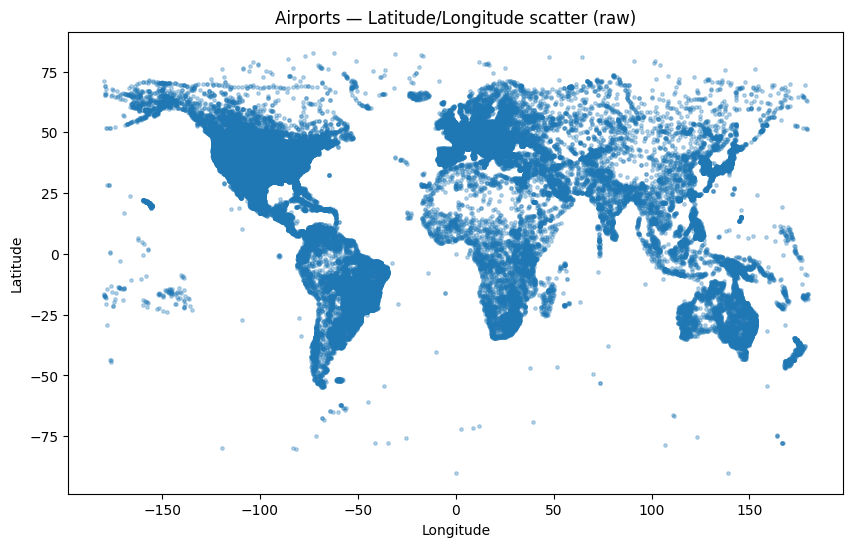

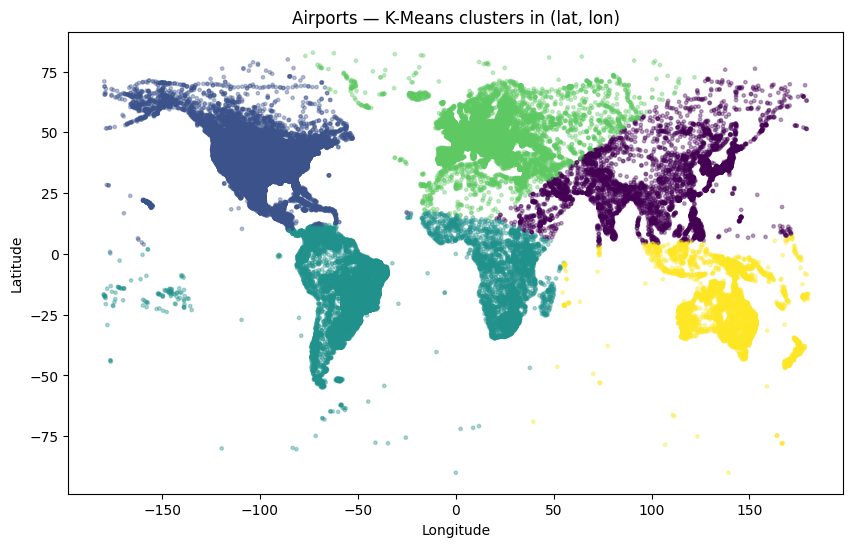

,elevation_ft,robust_z
49652,17372.0,19.027499
49654,17347.0,18.998919
31377,16200.0,17.687663
19381,15988.0,17.445303
19473,15131.0,16.465577
19378,14997.0,16.312388
61384,14965.0,16.275805
19376,14859.0,16.154625
51569,14809.0,16.097465
19379,14730.0,16.007152


In [22]:
a = df_airports.copy()
for c in ["latitude_deg","longitude_deg","elevation_ft"]:
    if c in a.columns:
        a[c] = pd.to_numeric(a[c], errors="coerce")

a = a.dropna(subset=["latitude_deg","longitude_deg"]).copy()

plt.figure(figsize=(10, 6))
plt.scatter(a["longitude_deg"], a["latitude_deg"], s=6, alpha=0.3)
plt.title("Airports — Latitude/Longitude scatter (raw)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# K-Means clusters as an EDA lens
X = a[["latitude_deg","longitude_deg"]].to_numpy()
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

k = 5
km = KMeans(n_clusters=k, random_state=42, n_init=10)
a["cluster"] = km.fit_predict(Xz)

plt.figure(figsize=(10, 6))
plt.scatter(a["longitude_deg"], a["latitude_deg"], c=a["cluster"], s=6, alpha=0.35)
plt.title("Airports — K-Means clusters in (lat, lon)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Elevation outliers (robust z-score using MAD)
if "elevation_ft" in a.columns:
    elev = a["elevation_ft"].dropna()
    med = elev.median()
    mad = (elev - med).abs().median()
    rz = (elev - med) / (1.4826 * mad) if mad > 0 else (elev - med) / elev.std(ddof=0)
    out = elev.to_frame("elevation_ft").assign(robust_z=rz).sort_values("robust_z", ascending=False).head(12)
    display(out)


## ۱۴) الگوهای پرت (Diamonds): Isolation Forest

تشخیص پرت می‌تواند موارد زیر را آشکار کند:

- خطاهای داده (ابعاد ناممکن)،
- موارد نادر اما معتبر با ارزش بالا،
- یا تغییر رژیم.

در ادامه از Isolation Forest روی مجموعه‌ای از ستون‌های عددی استفاده می‌کنیم و نقاط پرچم‌گذاری‌شده را تجسم می‌کنیم.


,carat,depth,table,price,x,y,z,anomaly_score,is_outlier
27649,3.01,57.6,64.0,18593,9.44,9.38,5.42,0.747001,1
22831,3.00,57.0,64.0,10863,9.38,9.31,5.33,0.737148,1
23644,3.65,67.1,53.0,11668,9.53,9.48,6.38,0.736936,1
26431,3.40,66.8,52.0,15964,9.42,9.34,6.27,0.735960,1
22741,3.01,56.1,62.0,10761,9.54,9.38,5.31,0.731950,1
25899,2.48,56.7,66.0,15030,8.88,8.64,4.99,0.730288,1
23539,3.00,64.2,65.0,11548,9.08,8.96,5.79,0.725264,1
25850,3.00,59.3,64.0,14918,9.32,9.19,5.50,0.722557,1
27633,2.40,56.9,62.0,18541,8.87,8.81,5.03,0.721306,1
27516,3.01,65.8,56.0,18242,8.99,8.94,5.90,0.720800,1


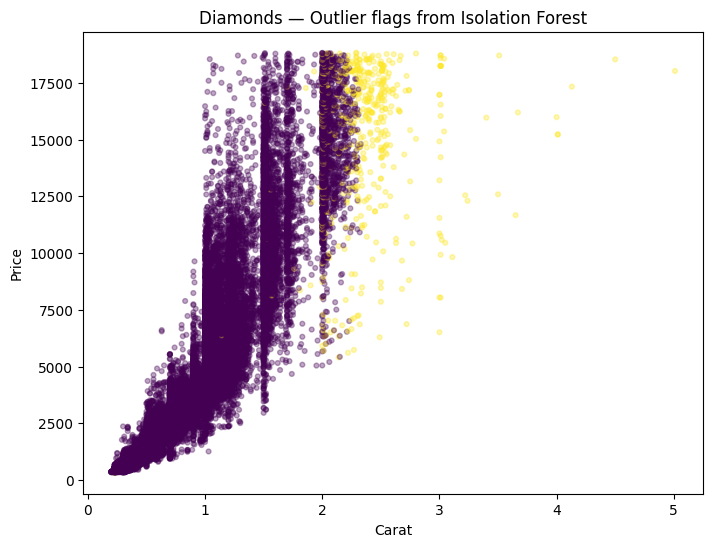

In [23]:
d4 = df_diamonds.copy()
cols = ["carat","depth","table","price","x","y","z"]
for c in cols:
    d4[c] = pd.to_numeric(d4[c], errors="coerce")
d4 = d4.dropna(subset=cols).copy()

X = d4[cols].values
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

iso = IsolationForest(n_estimators=300, random_state=42, contamination=0.01)
d4["is_outlier"] = (iso.fit_predict(Xz) == -1).astype(int)
d4["anomaly_score"] = -iso.score_samples(Xz)

display(d4.sort_values("anomaly_score", ascending=False).head(10)[cols + ["anomaly_score","is_outlier"]])

plt.figure(figsize=(8, 6))
plt.scatter(d4["carat"], d4["price"], c=d4["is_outlier"], s=12, alpha=0.35)
plt.title("Diamonds — Outlier flags from Isolation Forest")
plt.xlabel("Carat")
plt.ylabel("Price")
plt.show()


## ۱۵) استرس‌تست الگوها: CI بوت‌استرپ و آزمون جایگشتی

EDA اکتشافی است، اما می‌توان با تست‌های سبک آماری جلوی فریب‌خوردن را گرفت.

### CI بوت‌استرپ برای همبستگی

بوت‌استرپ ردیف‌ها را بازنمونه‌گیری می‌کند و آماره را دوباره محاسبه می‌کند. پراکندگی آن حس پایداری می‌دهد. در اینجا CI ۹۵٪ را برای موارد زیر می‌سنجیم:

- Spearman(BMI, Glucose) در diabetes
- Pearson(log(carat), log(price)) در diamonds

### آزمون جایگشتی برای اختلاف میانگین گروهی

جایگشت ارتباط ویژگی و برچسب را می‌شکند. اگر اختلاف مشاهده‌شده از اختلاف‌های جایگشتی بسیار دور باشد، احتمالاً الگو واقعی است.


In [24]:
mean_c, lo_c, hi_c = bootstrap_corr(df_diabetes["BMI"], df_diabetes["Glucose"], method="spearman", n_boot=1500)
print("Diabetes Spearman corr(BMI, Glucose):", mean_c, "CI95%:", (lo_c, hi_c))

tmp = df_diamonds.dropna(subset=["carat","price"]).copy()
tmp["carat"] = pd.to_numeric(tmp["carat"], errors="coerce")
tmp["price"] = pd.to_numeric(tmp["price"], errors="coerce")
tmp = tmp.dropna(subset=["carat","price"])

mean_c2, lo_c2, hi_c2 = bootstrap_corr(np.log(tmp["carat"]), np.log(tmp["price"]), method="pearson", n_boot=1500)
print("Diamonds Pearson corr(log(carat), log(price)):", mean_c2, "CI95%:", (lo_c2, hi_c2))

obs, p = permutation_test_mean_diff(df_diabetes["BMI"], df_diabetes["y"], n_perm=4000)
print("Observed mean(BMI|1) - mean(BMI|0):", obs)
print("Permutation p-value (two-sided):", p)


Diabetes Spearman corr(BMI, Glucose): 0.2320011698246673 CI95%: (0.16418212982072614, 0.29529791152323576)
Diamonds Pearson corr(log(carat), log(price)): 0.9659153674181634 CI95%: (0.9653718401237102, 0.9664167175446151)
Observed mean(BMI|1) - mean(BMI|0): nan
Permutation p-value (two-sided): nan


## ۱۶) جمع‌بندی و تمرین‌ها

### جمع‌بندی

در این درس یک جریان کار «الگو-محور» را روی چند نوع دیتاست تمرین کردید:

- تشخیص شکل تک‌متغیره (هیستوگرام، ECDF، Q-Q),
- بررسی رابطه دومتغیره (scatter/hexbin، پیرسون/اسپیرمن),
- غربال‌گری غیرخطی با MI,
- مقایسه گروهی با اندازه‌اثر و آزمون جایگشتی,
- فصل‌وارگی زمانی با میانگین روزِهفته و ACF,
- وابستگی دسته‌ای با کای-دو و Cramér’s V,
- تشخیص‌های سریع متنی با طول، مفقودی و واژه‌های پرتکرار,
- خوشه‌بندی مکانی و بررسی پرت‌های مقاوم.

هدف EDA این است که در پایان به یک **تصمیم** برسید: چه ویژگی‌هایی بسازید، چه خانواده مدل‌هایی را امتحان کنید، چه مشکلات داده‌ای را اصلاح کنید، و چه نوع تقسیم داده‌ای (تصادفی/زمانی/گروهی) مناسب‌تر است.

### تمرین‌ها (کدنویسی کنید)

1. (Diabetes) ویژگی‌های عددی را بر اساس قدرمطلق همبستگی اسپیرمن با برچسب `y` رتبه‌بندی کنید و سه تای اول را تفسیر کنید.
2. (Diamonds) نمودار میانه شرطی را این بار با `clarity` به جای `cut` تکرار کنید. کدام سگمنت شیب تندتری دارد؟
3. (Drug200) تحلیل جدول توافقی را برای `Cholesterol` × `Drug` انجام دهید و اندازه‌اثر را با BP × Drug مقایسه کنید.
4. (NYC collisions) میانگین‌های ماهِ سال را محاسبه و با میانگین‌های روزِهفته مقایسه کنید. کدام قوی‌تر است؟
5. (Consumer complaints) اگر “State Name” وجود دارد، نرخ مفقودی روایت را به تفکیک ایالت حساب کنید. آیا الگوی مکانی قوی می‌بینید؟
6. (Airports) خوشه‌بندی را با k=8 امتحان کنید و خوشه‌ها را بصری مقایسه کنید. تغییر k چه اثری روی تفسیرپذیری دارد؟

### مینی‌پروژه

یک دیتاست را انتخاب کنید و یک روایت ۱–۲ صفحه‌ای EDA بنویسید:

- چه الگوهایی دیدید؟
- چطور آن‌ها را اعتبارسنجی کردید؟
- پنج گام بعدی پیشنهادی شما برای مدل‌سازی یا پاکسازی داده چیست؟
